In [21]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['mathtext.fontset'] = 'stix'

In [22]:
device = torch.device("cpu")

### Defining netwroks with two linear layers. The network reads 3 parameters D_in, H, D_out, where H is the hidden dimension. The linear network works as two matrix multiplication. The first linear layer clamps output at 0 as RELU. The second linear layer output logits.

In [23]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, D_in, H, D_out):    
        super(TwoLayerNet, self).__init__()
        
        self.linear1=nn.Linear(D_in, H)
        self.linear2=nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        
        return y_pred

### Predefined parameters

In [24]:
# N=number of sample, D_in=Input dimensions, H=Hidden dimension, D_out=Number of classes
N, D_in, H, D_out = 50, 200, 100, 10
mus = range(D_out) # means
train_sigma = 0.4 # standard deviation
data_sigma = train_sigma
data_mus = np.arange(0.5,10.5,0.25)

# Learning rate
lr=5e-4
# Number of optimization
num_ops=10000 # try 10000!

### Predefined data

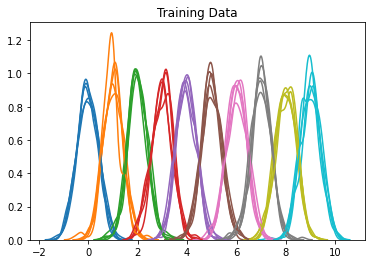

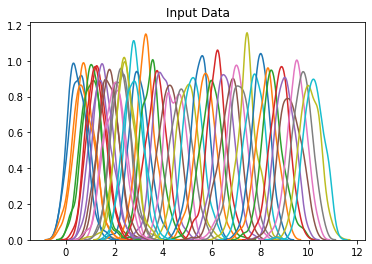

In [25]:
# Input data

X = torch.tensor(np.array([np.sort(np.random.normal(mus[i%D_out], train_sigma, D_in)) for i in range(N)]), dtype=torch.float32)
    
X_test = torch.tensor(np.array([np.sort(np.random.normal(data_mus[i%len(data_mus)], \
                                            data_sigma, D_in)) for i in range(N)]), dtype=torch.float32)

y = torch.zeros(N, dtype=torch.long)
for i,x in enumerate(X):
    y[i] = round(float(torch.mean(x)))

for data in X:
    sns.distplot(data, hist = False)
plt.title('Training Data')
plt.show()
    
for x in X_test:
    sns.distplot(x, hist = False)
# plt.boxplot(X.tolist())
plt.title('Input Data')
plt.show()


def normalize(target_dist, N):
    scale = N/np.sum(target_dist)
    return target_dist*scale

target_dist = normalize(np.array([1,2,4,8,16,8,4,2,1,0.5]), N)

# Artifical energy levels
#E=np.array([[i+1 for i in range(D_out)] for j in range(N)])
#E=torch.tensor(E, dtype=torch.float32)

In [26]:
print(X.shape)
print(y.shape)

torch.Size([50, 200])
torch.Size([50])


### Predefined functions

In [27]:
softmax=torch.nn.Softmax(dim=-1)

### Building model

In [28]:
model = TwoLayerNet(D_in, H, D_out)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

"The hand-tuned
penalty parameter for the fixed penalty method is set to 0.3, which, for
this problem, yielded the best training results by balancing the relative magnitudes of the mean squared error loss function and the 2-norm of the conservation constraints. The aug-Lag method, on the other hand, is initialized
with Lagrange multipliers set to zero, penalty factor µinit = 100, penalty
update factor σ = 2, and penalty safeguard µmax = 109
.
Both training methods utilize a batch size of nbatch = 128 and are limited
to the same number of passes over the data set. The aug-Lag method is
configured to shuffle the data nshuffle = 3 times and perform naug−Lag = 10"

### Training

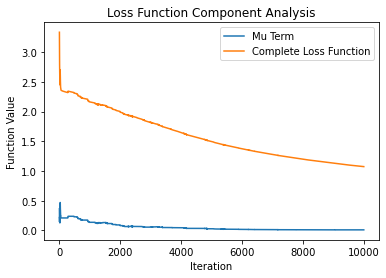

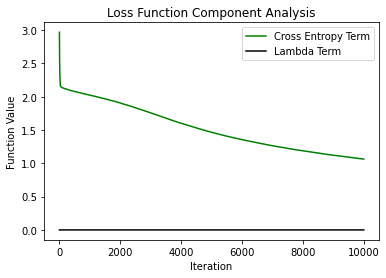

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


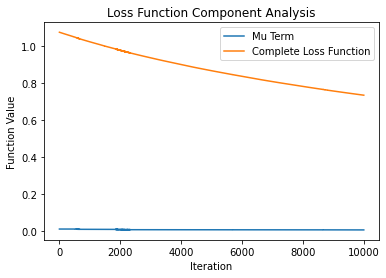

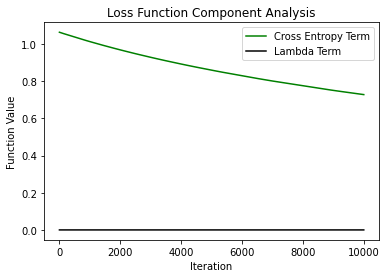

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


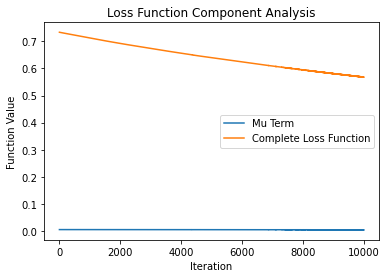

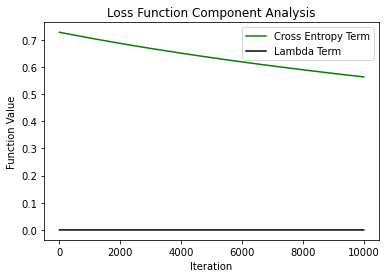

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


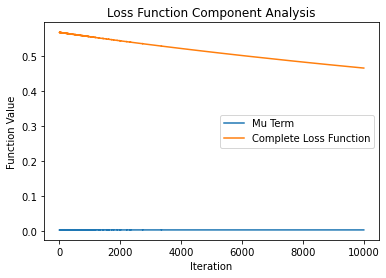

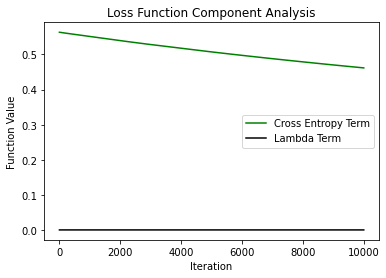

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


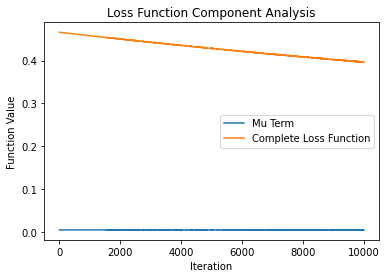

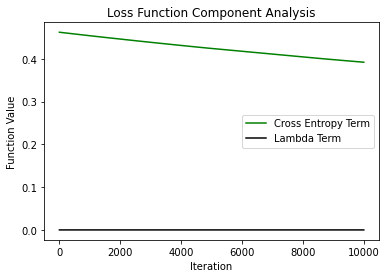

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


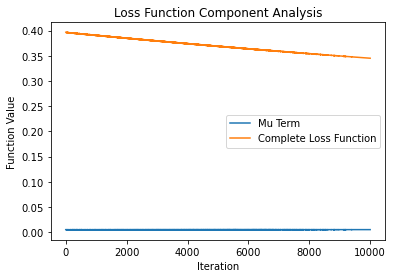

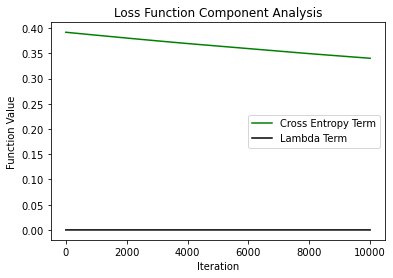

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


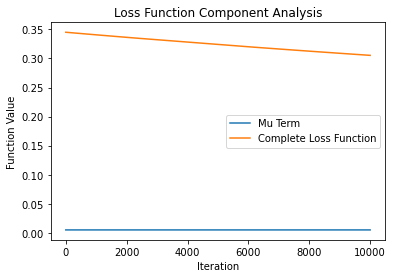

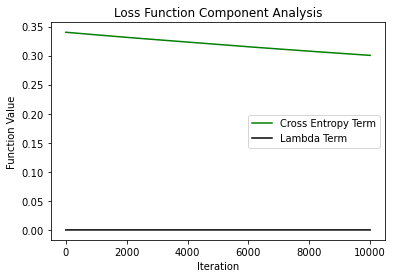

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


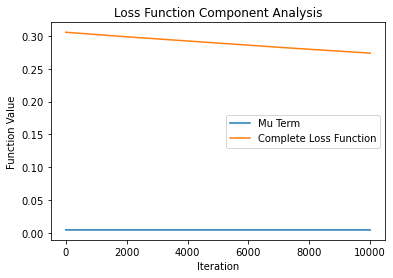

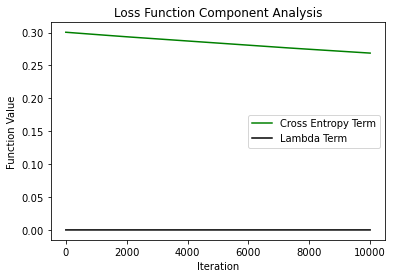

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


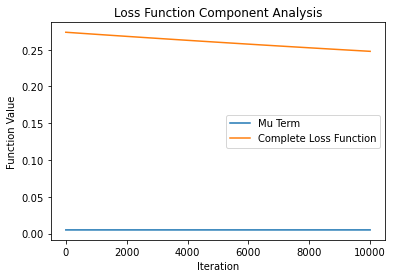

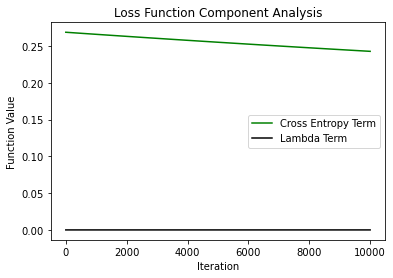

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


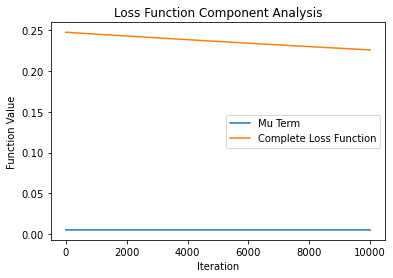

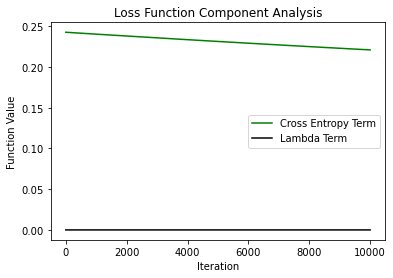

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


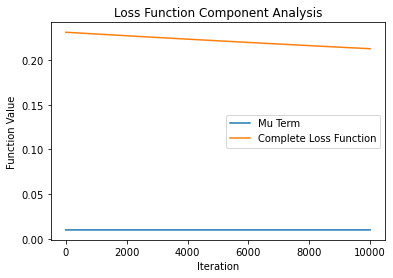

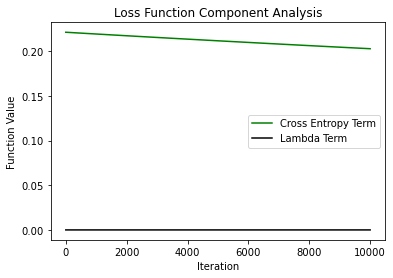

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


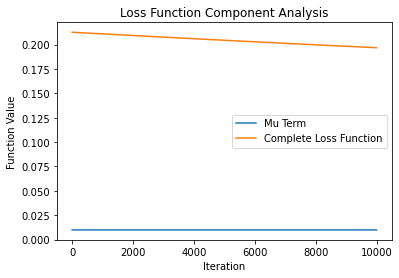

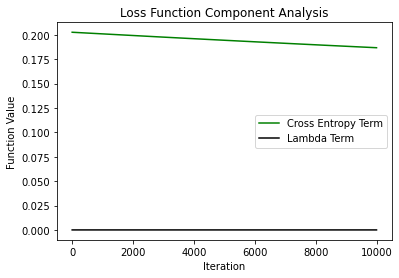

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


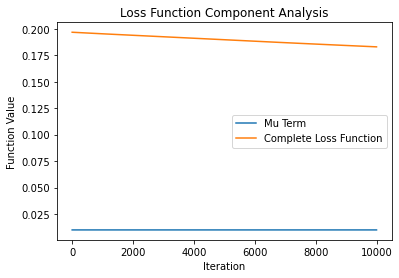

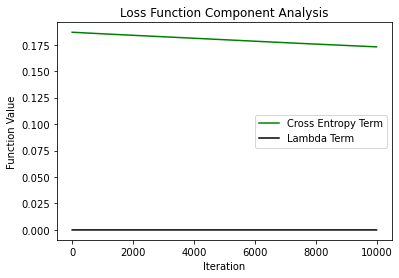

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


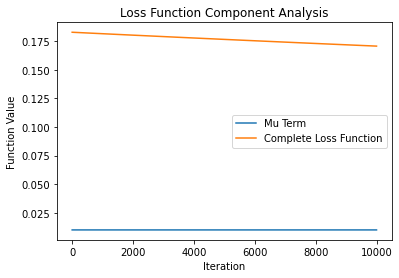

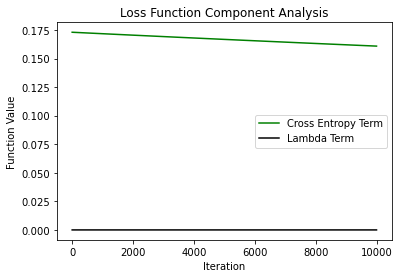

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


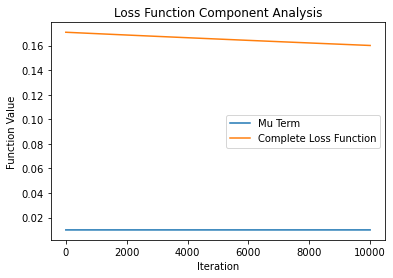

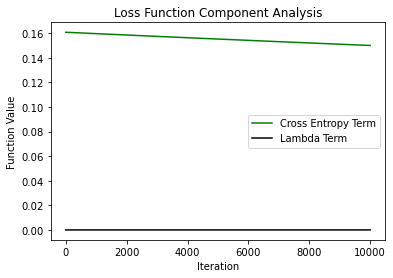

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


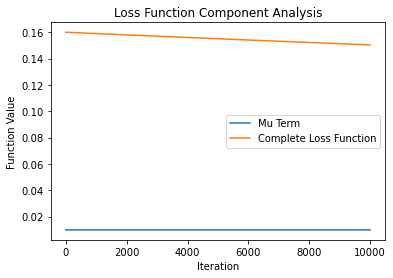

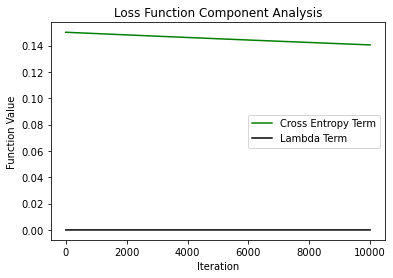

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


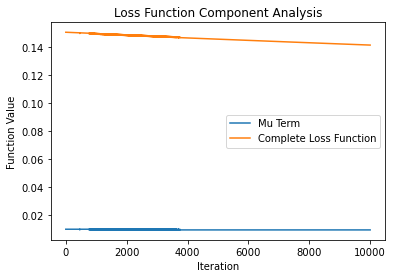

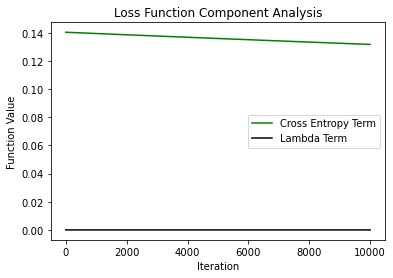

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


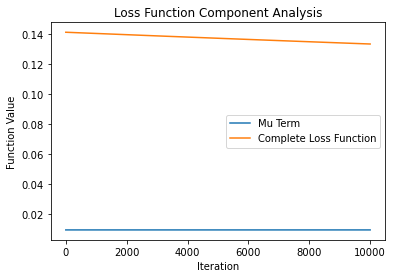

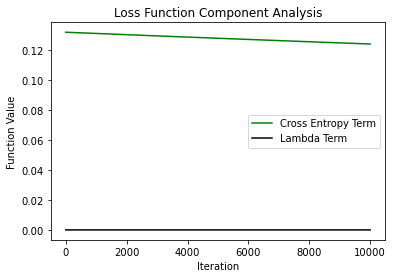

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


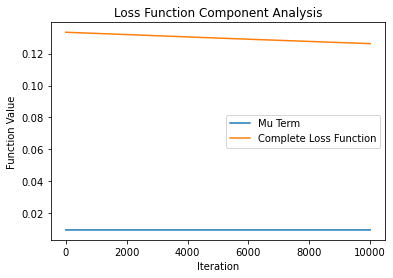

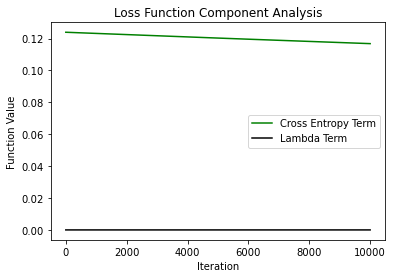

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


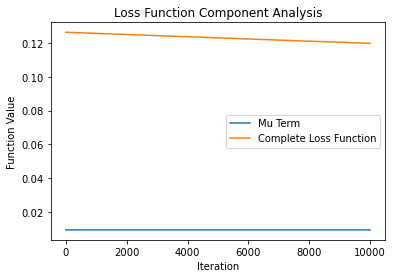

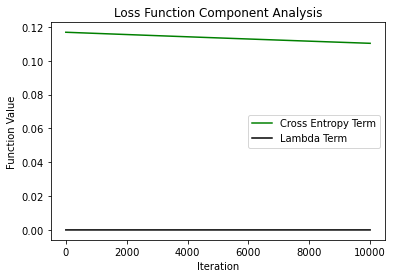

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


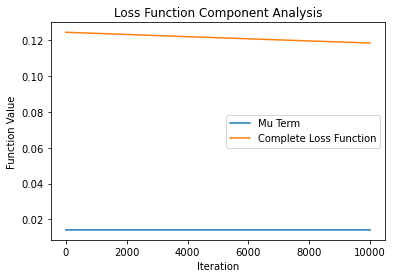

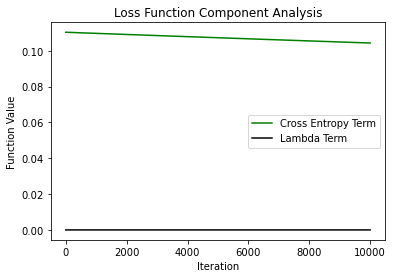

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


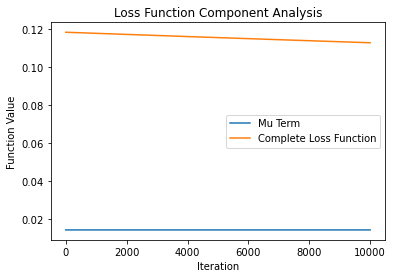

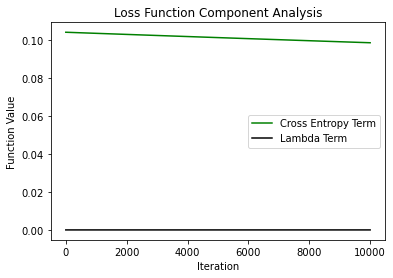

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


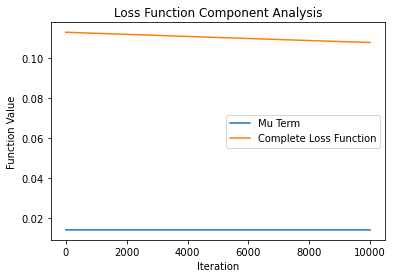

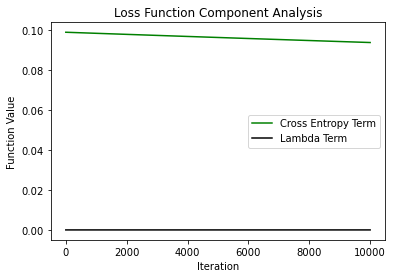

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


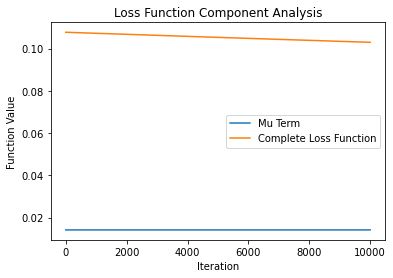

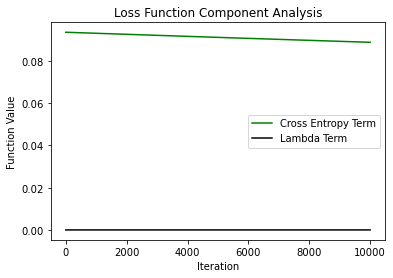

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


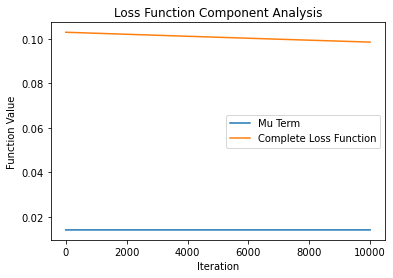

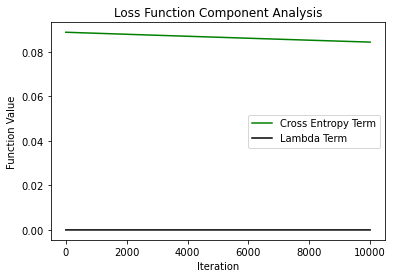

left the optimization loop
torch.square(C_next) <= n*torch.square(C_best)
Solution not found


KeyboardInterrupt: 

In [29]:
index = []
losses = {'cross_entropy': [], 'lambda_term': [], 'mu_term': [], 'total': []}

# Parameters to set according to paper
n_shuffle = 3
mu_init = 100
# penalty update factor
sigma = 2 
# penalty safeguard
mu_max = 109
# batch size
n_batch = 128
# number of aug-lag iterations per shuffle
n_auglag = 10

# NOT given in the paper, so I Guessed
n = 1.3 # update tolerance 
e_f = 0.01 # convergence tolerance of f
e_c = 0.01 # convergence tolerance of C


# target distribution is the constraint distribution and output is the classifications made by the model
def mse_dist(target_dist, output):
    obs_dist = np.zeros(len(target_dist))
    for c in output:
        obs_dist[c-1] += 1
        
    scale = np.sum(target_dist)
    mse = np.mean(np.square(target_dist/scale - obs_dist/scale))
    return mse

# this is the constraint function as a function of p
C_best = mse_dist(target_dist ,np.argmax(softmax(model(X)).detach().numpy(), axis=1))
# Lagrange multiplier
l = torch.tensor(0, requires_grad=True, dtype=torch.float32)

def weights_init(m):
    torch.nn.init.ones_(m.weight.data)

for shuffle in range(n_shuffle+1):
    mu = (shuffle+1)*mu_init
    for k in range(n_auglag):
        index = []
        losses = {'cross_entropy': [], 'lambda_term': [], 'mu_term': [], 'total': []}
        auglag_iteration = []
        constants = {'mu': [], 'lambda': []}
        #model.linear1.apply(weights_init)
        #model.linear2.apply(weights_init)
        for i in range(num_ops):
            Y=model(X)
    
            cross_entropy = loss_fn(Y, y)
            lambda_term = l*mse_dist(target_dist, np.argmax(softmax(Y).detach().numpy(), axis=1))
            mu_term = 0.5*mu*mse_dist(target_dist, np.argmax(softmax(Y).detach().numpy(), axis=1))**2
        
            loss = cross_entropy + lambda_term + mu_term
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #if i%600 == 0:
            #    print('loss optimization loop')
            
            index.append(i)
            losses['cross_entropy'].append(cross_entropy)
            losses['lambda_term'].append(lambda_term)
            losses['mu_term'].append(mu_term)
            losses['total'].append(cross_entropy + lambda_term + mu_term)
            
            
        plt.plot(index,losses['mu_term'], label = 'Mu Term')
        plt.plot(index,losses['total'], label = 'Complete Loss Function')
        plt.title('Loss Function Component Analysis')
        plt.xlabel('Iteration')
        plt.ylabel('Function Value')
        #plt.plot(index, np.zeros(len(index)),'r--', label = '0')
        plt.legend()
        plt.show()
        
        plt.plot(index,losses['cross_entropy'], label = 'Cross Entropy Term', color = 'g')
        plt.plot(index,losses['lambda_term'], label = 'Lambda Term', color = 'k')
        plt.title('Loss Function Component Analysis')
        plt.xlabel('Iteration')
        plt.ylabel('Function Value')
        plt.legend()
        plt.show()
        
        print('left the optimization loop')    
        #Y_ = model.detach()(X)
        C_next = mse_dist(target_dist, np.argmax(softmax(Y).detach().numpy(), axis=1))
        if C_next**2 <= n*C_best**2:
            print('torch.square(C_next) <= n*torch.square(C_best)')
            if loss_fn(Y,y) <= e_f and torch.square(C_next) <= e_c:
                print("Solution found")
            else:
                print('Solution not found, update l')
                l.data.add(mu*C_next)
                C_best = C_next
                # mu = mu
        else:
            # l = l 
            mu = min(sigma*mu, mu_max)
            print('update mu')
            
        constants['mu'].append(mu)
        constants['lambda'].append(l)
        auglag_iteration.append(k)
    # l = l

    
        #loss = l*(E_mean-torch.mean(E*softmax(Y)))
    
#    if i % 1000 == 999:
#        print(i, loss.item())

    
#    index.append(i)
#    losses['cross_entropy'].append(cross_entropy.item())
#    losses['residual_sqr_term'].append(residual_sqr_term.item())
#    losses['total_loss'].append(loss.item())
    
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()
#    l.data.add_(-lr*l.grad.data)
#    l.grad.zero_()
    
print('(E,l)={} {:.3}'.format(E_mean, l.data))

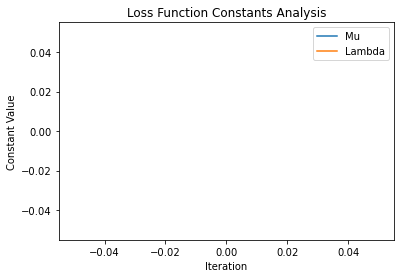

In [30]:
plt.plot(auglag_iteration,constants['mu'], label = 'Mu')
plt.title('Loss Function Constants Analysis')
plt.xlabel('Iteration')
plt.ylabel('Constant Value')
plt.plot(auglag_iteration, constants['lambda'], label = 'Lambda')
plt.legend()
plt.show()

In [31]:
print(constants['mu'])

[]


# *NOTE* Everything past this point I haven't updated 

### Checking performance of model

In [ ]:
test_X = torch.randn(N, D_in)
test_Y=model(test_X)

plt.rcParams['figure.figsize']=(6,5)
plt.plot(softmax(test_Y).detach().numpy()[0])
plt.tick_params(axis='both', which='both', labelsize=16)
plt.xlabel('Index', size=16)
plt.ylabel('Prob', size=16)
plt.show()

## Training with different observed average energy

### Predefined parameters

In [ ]:
E_mean_list=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]

### Predefined functions

In [ ]:
def compute_l(X, l, D_in, H, D_out, num_ops):
    """
    Compute Langrange multiplier l.
    """

    for i in range(num_ops):
        Y=model(X)
        loss = loss_fn(Y, y)+l*(E_mean-torch.mean(E*softmax(Y)))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        l.data.add_(-lr*l.grad.data)
        l.grad.zero_()
    
    return l.data.item()


### Trainings

In [ ]:
ls=[]
for E_mean in E_mean_list:
    
    X = torch.randn(N, D_in)
    l = torch.tensor(1, requires_grad=True, dtype=torch.float32)
    l_final = compute_l(X, l, D_in, H, D_out, num_ops)
    print(l_final)
    ls.append(l_final)
    

### Checking the behavior.

In [ ]:
E_mean_list=np.array(E_mean_list)
ls=np.array(ls)

fig, ax=plt.subplots(figsize=(6,5))
ax.scatter(E_mean_list, ls*E_mean_list)
ax.tick_params(axis='both', which='both', direction='in', labelsize=16)
ax.set_xlabel('$\overline{E}$', size=16)
ax.set_ylabel('$\\beta*\overline{E}$', size=16)

plt.show()